### Cross validation
This notebook performs a round of cross validation of the model on the training data.
As training data, the filtered and randomized fivefold split data created by `sort_training_data.ipynb` and `generate_gold_splits` is used.
In addition to detailed output in markdown format, precision-recall curves and precision-recall-vs-threshold curves are generated for each fold.

### Usage
To set the model to be evaluated, the `model_name` variable has to be adjusted in the third cell.

All further parameters are set below, where the according description can be found.

In [2]:
import numpy as np
import json
import random
from random import randrange 
import scipy
from sklearn.metrics import cohen_kappa_score, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve

In [3]:
# generate random seed
seed = randrange(100000)
print(f"seed: {seed}")
random.seed(seed)

seed: 42987


In [4]:
#usage_embeddings_split = "../cross_validation/usage_embeddings_split.json"
model_name = "wordnet_sense_id_gloss_[3]"
#dictionary_embeddings_file = "../embeddings/scripts/xl-lexeme/examples[6]_3embeddings.json"

#dictionary_embeddings_file = f"../../../embeddings/scripts/xl-lexeme/swedish/{model_name}_embeddings.json"
dictionary_embeddings_file = f"../data/outputs/sense_embeddings/english/{model_name}_embeddings.json"

In [5]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [6]:
def spearmanr(x, y):
    return scipy.stats.spearmanr(x, y)[0]

In [7]:
with open(dictionary_embeddings_file) as f:
    dictionary_embeddings = json.load(f)

In [8]:
def calculate_similarities(split_file, sim_measure):
    with open(split_file) as f:
        usage_embeddings = json.load(f)
            
        # compare sense embeddings with usage embeddings
        unknown_senses = usage_embeddings["unknown_senses"]
        #print(unknown_senses)
        results = []
        for usage in usage_embeddings["data"]:
            lemma = usage["lemma"] # task data
            usage_embedding = usage["embedding"] # task data

            assigned = usage["assigned"] # gold data

            if lemma not in dictionary_embeddings.keys():
                print(f"lemma {lemma} not found in dictionary")
                continue
            dictionary_entry = dictionary_embeddings[lemma] # dictionary entry of lemma

            sense_ranking = []
            
            # collect all senses that have usages
            sense_inventory = []
            for sense in dictionary_entry:
                if sense["usages"] !=[] and sense["sense"] not in unknown_senses: # filter out senses without usages
                    sense_inventory.append(sense)

                    
            if sense_inventory == []:
                senses = [sense["sense"] for sense in dictionary_entry if sense["usages"] != []]
                print(f"empty sense inventory for {lemma}")
                #print(f"found senses: {senses}")
                #most_frequent_similarity = 0.5 # faile safe, when no sense is found, assign 0.5
            else:
                sense_embedding = sense_inventory[0]["embedding"]
                if sim_measure == "cosine":
                    most_frequent_similarity = cosine_similarity(usage_embedding, sense_embedding)    
                elif sim_measure == "spearmanr":
                    most_frequent_similarity = spearmanr(usage_embedding, sense_embedding)

            for sense in sense_inventory:
                sense_embedding = sense["embedding"]

                # calculate similarity
                if sim_measure == "cosine":
                    similarity = cosine_similarity(usage_embedding, sense_embedding)
                elif sim_measure == "spearmanr":
                    similarity = spearmanr(usage_embedding, sense_embedding)
                
                sense_ranking.append(similarity)


            
            
            sense_ranking = sorted(sense_ranking, reverse=True)
        #    sense_ranking = sorted(sense_ranking, key=lambda x: x["similarity"], reverse=True)

            results.append({
                "lemma": lemma,
                "fold": usage["fold"],
                "assigned": assigned,
                "sense_ranking": sense_ranking,
                "most_frequent_sense": most_frequent_similarity,
            })

        return results

In [9]:
# compares 
def evaluate(threshold, splits, results):
    gold_annotations = []
    model_annotations = []
    random_annotations = []
    frequency_annotations = []
    minority_annotations = []
    majority_annotations = []

    for res in results:
        if res["fold"] in splits: # only evaluate on the splits we want
            unassigned = not res["assigned"] # gold data
            sense_ranking = res["sense_ranking"] # task data

            if len(sense_ranking) == 0: # no senses in dictionary
                print(f"no senses for {res['lemma']}")
                continue
            
            gold_annotations.append(int(unassigned)) # append 1 if unassigned, 0 if assigned
            
            top_sense_similarity = sense_ranking[0] # similarity of top sense

            ratio = gold_annotations.count(0) / len(gold_annotations) # ratio of assigned senses

            model_annotations.append(int(top_sense_similarity < threshold)) # append 1 if unassigned 0 if assigned
            random_annotations.append(int(random.random() > ratio)) # append 1 if unassigned, 0 if assigned
            frequency_annotations.append(int(res["most_frequent_sense"] < threshold))
            minority_annotations.append(1) # always predict assigned, because majority is assigned
            majority_annotations.append(int(random.random() > 0.9)) # predict assigned with 90% probability


    return {
        "splits": splits,
        "threshold": threshold,
        "gold_annotations": gold_annotations,
        "model_annotations": model_annotations,
        "random_annotations": random_annotations,
        "frequency_annotations": frequency_annotations,
        "minority_annotations": minority_annotations,
        "majority_annotations": majority_annotations,
    }

In [10]:
# calculate measurements for a single threshold
def calculate_measurements(res):
    gold_annotations = res["gold_annotations"]
    model_annotations = res["model_annotations"]
    random_annotations = res["random_annotations"]
    frequency_annotations = res["frequency_annotations"]
    minority_annotations = res["minority_annotations"]
    majority_annotations = res["majority_annotations"]

    # calculate f_beta, krippendorff_alpha, cohens_kappa
    f_5 = fbeta_score(gold_annotations, model_annotations, average="binary", beta=0.5)
    f_3 = fbeta_score(gold_annotations, model_annotations, average="binary", beta=0.3)
    f_1 = fbeta_score(gold_annotations, model_annotations, average="binary", beta=0.1)
    
    # calulate random 
    random_f_5 = fbeta_score(gold_annotations, random_annotations, average="binary", beta=0.5)
    random_f_3 = fbeta_score(gold_annotations, random_annotations, average="binary", beta=0.3)
    random_f_1 = fbeta_score(gold_annotations, random_annotations, average="binary", beta=0.1)
    
    # calulate frequency
    frequency_f_5 = fbeta_score(gold_annotations, frequency_annotations, average="binary", beta=0.5)
    frequency_f_3 = fbeta_score(gold_annotations, frequency_annotations, average="binary", beta=0.3)
    frequency_f_1 = fbeta_score(gold_annotations, frequency_annotations, average="binary", beta=0.1)
    
    # calulate minority
    minority_f_5 = fbeta_score(gold_annotations, minority_annotations, average="binary", beta=0.5)
    minority_f_3 = fbeta_score(gold_annotations, minority_annotations, average="binary", beta=0.3)
    minority_f_1 = fbeta_score(gold_annotations, minority_annotations, average="binary", beta=0.1)
    
    # calulate majority
    majority_f_5 = fbeta_score(gold_annotations, majority_annotations, average="binary", beta=0.5)
    majority_f_3 = fbeta_score(gold_annotations, majority_annotations, average="binary", beta=0.3)
    majority_f_1 = fbeta_score(gold_annotations, majority_annotations, average="binary", beta=0.1)
    
    # calculate accuracy, precision, recall
    accuracy = accuracy_score(gold_annotations, model_annotations)
    precision = precision_score(gold_annotations, model_annotations, zero_division=0)
    recall = recall_score(gold_annotations, model_annotations, zero_division=0)

    tp = sum([1 for i in range(len(gold_annotations)) if gold_annotations[i] == 1 and model_annotations[i] == 1])
    fp = sum([1 for i in range(len(gold_annotations)) if gold_annotations[i] == 0 and model_annotations[i] == 1])
    fn = sum([1 for i in range(len(gold_annotations)) if gold_annotations[i] == 1 and model_annotations[i] == 0])
    tn = sum([1 for i in range(len(gold_annotations)) if gold_annotations[i] == 0 and model_annotations[i] == 0])

    return {
        "split_label": res["splits"],
        "threshold": res["threshold"],
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f_5": f_5,
        "f_3": f_3,
        "f_1": f_1,
        "tp": tp,
        "fp": fp,
        "fn": fn,
        "tn": tn,
        "random_f_5": random_f_5,
        "random_f_3": random_f_3,
        "random_f_1": random_f_1,        
        "frequency_f_5": frequency_f_5,
        "frequency_f_3": frequency_f_3,
        "frequency_f_1": frequency_f_1,
        "minority_f_5": minority_f_5,
        "minority_f_3": minority_f_3,
        "minority_f_1": minority_f_1,
        "majority_f_5": majority_f_5,
        "majority_f_3": majority_f_3,
        "majority_f_1": majority_f_1,
    }

In [11]:
def cross_validate(test_splits, results):
    train_results = []
    train_splits = [s for s in range(5) if s not in test_splits] # all splits except the one we want to test on

    for t in range(0, 100, 1): # test all thresholds from 0 to 1
        threshold = t/100
        out = evaluate(threshold, train_splits, results) # evaluate on all splits except the one we want to test on 
        out["split"] = test_splits # add split label
        train_results.append(calculate_measurements(out)) # calculate measurements for each threshold

    # sort results by f, krippendorff_alpha, cohens_kappa
    train_results_f_5 = sorted(train_results, key=lambda x: x["f_5"], reverse=True) 
    train_results_f_3 = sorted(train_results, key=lambda x: x["f_3"], reverse=True)
    train_results_f_1 = sorted(train_results, key=lambda x: x["f_1"], reverse=True)

    # use best threshold of each measurement to evaluate on test data
    test_f_5 = calculate_measurements(evaluate(train_results_f_5[0]["threshold"], test_splits, results))
    test_f_3 = calculate_measurements(evaluate(train_results_f_3[0]["threshold"], test_splits, results))
    test_f_1 = calculate_measurements(evaluate(train_results_f_1[0]["threshold"], test_splits, results))

    # random baseline
    random_results_f_5 = sorted(train_results, key=lambda x: x["random_f_5"], reverse=True)
    random_results_f_3 = sorted(train_results, key=lambda x: x["random_f_3"], reverse=True)
    random_results_f_1 = sorted(train_results, key=lambda x: x["random_f_1"], reverse=True)

    # random baseline test
    test_f_5_random = calculate_measurements(evaluate(random_results_f_5[0]["threshold"], test_splits, results))
    test_f_3_random = calculate_measurements(evaluate(random_results_f_3[0]["threshold"], test_splits, results))
    test_f_1_random = calculate_measurements(evaluate(random_results_f_1[0]["threshold"], test_splits, results))

    # frequency baseline
    frequency_results_f_5 = sorted(train_results, key=lambda x: x["frequency_f_5"], reverse=True)
    frequency_results_f_3 = sorted(train_results, key=lambda x: x["frequency_f_3"], reverse=True)
    frequency_results_f_1 = sorted(train_results, key=lambda x: x["frequency_f_1"], reverse=True)
    
    # frequency baseline test
    test_f_5_frequency = calculate_measurements(evaluate(frequency_results_f_5[0]["threshold"], test_splits, results))
    test_f_3_frequency = calculate_measurements(evaluate(frequency_results_f_3[0]["threshold"], test_splits, results))
    test_f_1_frequency = calculate_measurements(evaluate(frequency_results_f_1[0]["threshold"], test_splits, results))

    # minority baseline
    minority_results_f_5 = sorted(train_results, key=lambda x: x["minority_f_5"], reverse=True)
    minority_results_f_3 = sorted(train_results, key=lambda x: x["minority_f_3"], reverse=True)
    minority_results_f_1 = sorted(train_results, key=lambda x: x["minority_f_1"], reverse=True)
    
    # minority baseline test
    test_f_5_minority = calculate_measurements(evaluate(minority_results_f_5[0]["threshold"], test_splits, results))
    test_f_3_minority = calculate_measurements(evaluate(minority_results_f_3[0]["threshold"], test_splits, results))
    test_f_1_minority = calculate_measurements(evaluate(minority_results_f_1[0]["threshold"], test_splits, results))

    # majority baseline
    majority_results_f_5 = sorted(train_results, key=lambda x: x["majority_f_5"], reverse=True)
    majority_results_f_3 = sorted(train_results, key=lambda x: x["majority_f_3"], reverse=True)
    majority_results_f_1 = sorted(train_results, key=lambda x: x["majority_f_1"], reverse=True)

    # majority baseline test
    test_f_5_majority = calculate_measurements(evaluate(majority_results_f_5[0]["threshold"], test_splits, results))
    test_f_3_majority = calculate_measurements(evaluate(majority_results_f_3[0]["threshold"], test_splits, results))
    test_f_1_majority = calculate_measurements(evaluate(majority_results_f_1[0]["threshold"], test_splits, results))

    return {
        "train_results": train_results,
        "f_5": {
            "training": train_results_f_5,
            "test": test_f_5
        },
        "f_3": {
            "training": train_results_f_3,
            "test": test_f_3
        },
        "f_1": {
            "training": train_results_f_1,
            "test": test_f_1
        },
        "random_f_5": {
            "training": random_results_f_5,
            "test": test_f_5_random
        },
        "random_f_3": {
            "training": random_results_f_3,
            "test": test_f_3_random
        },
        "random_f_1": {
            "training": random_results_f_1,
            "test": test_f_1_random
        },
        "frequency_f_5": {
            "training": frequency_results_f_5,
            "test": test_f_5_frequency
        },
        "frequency_f_3": {
            "training": frequency_results_f_3,
            "test": test_f_3_frequency
        },
        "frequency_f_1": {
            "training": frequency_results_f_1,
            "test": test_f_1_frequency
        },
        "minority_f_5": {
            "training": minority_results_f_5,
            "test": test_f_5_minority
        },
        "minority_f_3": {
            "training": minority_results_f_3,
            "test": test_f_3_minority
        },
        "minority_f_1": {
            "training": minority_results_f_1,
            "test": test_f_1_minority
        },
        "majority_f_5": {
            "training": majority_results_f_5,
            "test": test_f_5_majority
        },
        "majority_f_3": {
            "training": majority_results_f_3,
            "test": test_f_3_majority
        },
        "majority_f_1": {
            "training": majority_results_f_1,
            "test": test_f_1_majority
        }
    }

            

In [12]:
def print_results(cv_results):
    save = []
    for measure in ["f_5", "f_3", "f_1"]:
        average_threshold = np.mean([cv[measure]['test']['threshold'] for cv in cv_results])
        median_threshold = np.median([cv[measure]['test']['threshold'] for cv in cv_results])
        threshold_deviation = np.std([cv[measure]['test']['threshold'] for cv in cv_results])
        
        average_measure_training = np.mean([cv[measure]['training'][0][measure] for cv in cv_results]) # highest score of training
        average_measure_test = np.mean([cv[measure]['test'][measure] for cv in cv_results]) # score of test

        average_precision_training = np.mean([cv[measure]['training'][0]['precision'] for cv in cv_results])
        average_precision_test = np.mean([cv[measure]['test']['precision'] for cv in cv_results])

        average_recall_training = np.mean([cv[measure]['training'][0]['recall'] for cv in cv_results])
        average_recall_test = np.mean([cv[measure]['test']['recall'] for cv in cv_results])

        average_random_training = np.mean([cv[f'random_{measure}']['training'][0][f'random_{measure}'] for cv in cv_results])
        average_random_test = np.mean([cv[f'random_{measure}']['test'][f'random_{measure}'] for cv in cv_results])

        average_frequency_training = np.mean([cv[f'frequency_{measure}']['training'][0][f'frequency_{measure}'] for cv in cv_results])
        average_frequency_test = np.mean([cv[f'frequency_{measure}']['test'][f'frequency_{measure}'] for cv in cv_results])

        average_minority_training = np.mean([cv[f'minority_{measure}']['training'][0][f'minority_{measure}'] for cv in cv_results])
        average_minority_test = np.mean([cv[f'minority_{measure}']['test'][f'minority_{measure}'] for cv in cv_results])

        average_majority_training = np.mean([cv[f'majority_{measure}']['training'][0][f'majority_{measure}'] for cv in cv_results])
        average_majority_test = np.mean([cv[f'majority_{measure}']['test'][f'majority_{measure}'] for cv in cv_results])

      #  pr_curve = precision_recall_curve([cv[measure]['test']['gold_annotations'] for cv in cv_results], [cv[measure]['test']['model_annotations'] for cv in cv_results])

        threshold_splits = [cv[measure]['test']['threshold'] for cv in cv_results]
        measure_training_splits = [cv[measure]['training'][0][measure] for cv in cv_results]
        measure_test_splits = [cv[measure]['test'][measure] for cv in cv_results]

        precision_training_splits = [cv[measure]['training'][0]['precision'] for cv in cv_results]
        precision_test_splits = [cv[measure]['test']['precision'] for cv in cv_results]

        recall_training_splits = [cv[measure]['training'][0]['recall'] for cv in cv_results]
        recall_test_splits = [cv[measure]['test']['recall'] for cv in cv_results]

        random_training_splits = [cv[f'random_{measure}']['training'][0][f'random_{measure}'] for cv in cv_results]
        random_test_splits = [cv[f'random_{measure}']['test'][f'random_{measure}'] for cv in cv_results]

        frequency_training_splits = [cv[f'frequency_{measure}']['training'][0][f'frequency_{measure}'] for cv in cv_results]
        frequency_test_splits = [cv[f'frequency_{measure}']['test'][f'frequency_{measure}'] for cv in cv_results]

        minority_training_splits = [cv[f'minority_{measure}']['training'][0][f'minority_{measure}'] for cv in cv_results]
        minority_test_splits = [cv[f'minority_{measure}']['test'][f'minority_{measure}'] for cv in cv_results]

        majority_training_splits = [cv[f'majority_{measure}']['training'][0][f'majority_{measure}'] for cv in cv_results]
        majority_test_splits = [cv[f'majority_{measure}']['test'][f'majority_{measure}'] for cv in cv_results]

        save.append({
            "measure": measure,
            "average_threshold": average_threshold,
            "average_measure_training": average_measure_training,
            "average_measure_test": average_measure_test,
            "average_precision_training": average_precision_training,
            "average_precision_test": average_precision_test,
            "average_recall_training": average_recall_training,
            "average_recall_test": average_recall_test,
            "average_random_training": average_random_training,
            "average_random_test": average_random_test,
            "average_frequency_training": average_frequency_training,
            "average_frequency_test": average_frequency_test,
            "average_minority_training": average_minority_training,
            "average_minority_test": average_minority_test,
            "average_majority_training": average_majority_training,
            "average_majority_test": average_majority_test
        })

        # threshold table

        print(f"\n#### Threshold statistics")
        print(f"\n")

        print(f"| Measure          | Average  | Median | Deviation |")
        print(f"| ---------------- | -------- | ------ | --------- |")
        print(f"| {measure}        | {average_threshold:.3f}      | {median_threshold:.3f}    | {threshold_deviation:.3f}        |")

        print(f"\n")
        print(f"|                  | Average  |      | Fold 1  |      | Fold 2  |      | Fold 3  |      | Fold 4  |      | Fold 5  |      |")
        print(f"| ---------------- | -------- | ---- | -------- | ---- | -------- | ---- | -------- | ---- | -------- | ---- | -------- | ---- |")
        print(f"|                  | Training | Test | Training | Test | Training | Test | Training | Test | Training | Test | Training | Test |")
        print(f"| Threshold        | {average_threshold:.3f}      |      | {threshold_splits[0]:.3f}      |      | {threshold_splits[1]:.3f}      |      | {threshold_splits[2]:.3f}      |      | {threshold_splits[3]:.3f}      |      | {threshold_splits[4]:.3f}      |      |")
        print(f"| Precision        | {average_precision_training:.3f}      | {average_precision_test:.3f}      | {precision_training_splits[0]:.3f}      | {precision_test_splits[0]:.3f}      | {precision_training_splits[1]:.3f}      | {precision_test_splits[1]:.3f}      | {precision_training_splits[2]:.3f}      | {precision_test_splits[2]:.3f}      | {precision_training_splits[3]:.3f}      | {precision_test_splits[3]:.3f}      | {precision_training_splits[4]:.3f}      | {precision_test_splits[4]:.3f}      |")
        print(f"| Recall           | {average_recall_training:.3f}      | {average_recall_test:.3f}      | {recall_training_splits[0]:.3f}      | {recall_test_splits[0]:.3f}      | {recall_training_splits[1]:.3f}      | {recall_test_splits[1]:.3f}      | {recall_training_splits[2]:.3f}      | {recall_test_splits[2]:.3f}      | {recall_training_splits[3]:.3f}      | {recall_test_splits[3]:.3f}      | {recall_training_splits[4]:.3f}      | {recall_test_splits[4]:.3f}      |")
        print(f"| {measure}        | {average_measure_training:.3f}      | {average_measure_test:.3f}      | {measure_training_splits[0]:.3f}      | {measure_test_splits[0]:.3f}      | {measure_training_splits[1]:.3f}      | {measure_test_splits[1]:.3f}      | {measure_training_splits[2]:.3f}      | {measure_test_splits[2]:.3f}      | {measure_training_splits[3]:.3f}      | {measure_test_splits[3]:.3f}      | {measure_training_splits[4]:.3f}      | {measure_test_splits[4]:.3f}      |")
        print(f"| random_{measure} | {average_random_training:.3f}      | {average_random_test:.3f}      | {random_training_splits[0]:.3f}      | {random_test_splits[0]:.3f}      | {random_training_splits[1]:.3f}      | {random_test_splits[1]:.3f}      | {random_training_splits[2]:.3f}      | {random_test_splits[2]:.3f}      | {random_training_splits[3]:.3f}      | {random_test_splits[3]:.3f}      | {random_training_splits[4]:.3f}      | {random_test_splits[4]:.3f}      |")
        print(f"| frequency_{measure} | {average_frequency_training:.3f}      | {average_frequency_test:.3f}      | {frequency_training_splits[0]:.3f}      | {frequency_test_splits[0]:.3f}      | {frequency_training_splits[1]:.3f}      | {frequency_test_splits[1]:.3f}      | {frequency_training_splits[2]:.3f}      | {frequency_test_splits[2]:.3f}      | {frequency_training_splits[3]:.3f}      | {frequency_test_splits[3]:.3f}      | {frequency_training_splits[4]:.3f}      | {frequency_test_splits[4]:.3f}      |")
        print(f"| minority_{measure} | {average_minority_training:.3f}      | {average_minority_test:.3f}      | {minority_training_splits[0]:.3f}      | {minority_test_splits[0]:.3f}      | {minority_training_splits[1]:.3f}      | {minority_test_splits[1]:.3f}      | {minority_training_splits[2]:.3f}      | {minority_test_splits[2]:.3f}      | {minority_training_splits[3]:.3f}      | {minority_test_splits[3]:.3f}      | {minority_training_splits[4]:.3f}      | {minority_test_splits[4]:.3f}      |")
        print(f"| majority_{measure} | {average_majority_training:.3f}      | {average_majority_test:.3f}      | {majority_training_splits[0]:.3f}      | {majority_test_splits[0]:.3f}      | {majority_training_splits[1]:.3f}      | {majority_test_splits[1]:.3f}      | {majority_training_splits[2]:.3f}      | {majority_test_splits[2]:.3f}      | {majority_training_splits[3]:.3f}      | {majority_test_splits[3]:.3f}      | {majority_training_splits[4]:.3f}      | {majority_test_splits[4]:.3f}      |")

    return save

Adjust further variables below:
- `similarity_measure`: Either `cosine` or `spearmanr`
- adjust the range of the first for-loop to the number of rounds of cross validation to be performed (note that there need to be enough split files in the according directory)

In [13]:
model_results = []
average_saves = []
#similarity_measure = "spearmanr"
similarity_measure = "cosine"
for fold_split in range(1, 2):
    split_file = f"../data/outputs/cross_validation/FILTERED_english_assigned_usage_embeddings_{fold_split}.json"
    
    results = calculate_similarities(split_file, similarity_measure)
    cv_results = []
    for split in range(5): # 5-fold cross validation
        cv = cross_validate([split], results)
        cv_results.append(cv)

    print(f"\n### Round {fold_split}")
    save = print_results(cv_results)
    average_saves.append(save)
    
    model_results.append({
        "fold_split": fold_split,
        "measure": similarity_measure,
        "results": cv_results
    })

measures = []
f_5_saves = []
f_3_saves = []
f_1_saves = []

for a in average_saves:
    f_5_saves.extend([s for s in a if s["measure"] == "f_5"])
    f_3_saves.extend([s for s in a if s["measure"] == "f_3"])
    f_1_saves.extend([s for s in a if s["measure"] == "f_1"])

measures.extend(f_5_saves)
measures.extend(f_3_saves)
measures.extend(f_1_saves)

stats = {}

for m in ["f_5", "f_3", "f_1"]:
    for measure in measures:

        score_deviation = np.std([me["average_measure_training"] for me in measures if me["measure"] == m])
    
        average_threshold = np.mean([me["average_threshold"] for me in measures if me["measure"] == m])
        median_threshold = np.median([me["average_threshold"] for me in measures if me["measure"] == m])
        threshold_deviation = np.std([me["average_threshold"] for me in measures if me["measure"] == m])
        average_measure_training = np.mean([me["average_measure_training"] for me in measures if me["measure"] == m])
        average_measure_test = np.mean([me["average_measure_test"] for me in measures if me["measure"] == m])

        average_precision_training = np.mean([me["average_precision_training"] for me in measures if me["measure"] == m])
        average_precision_test = np.mean([me["average_precision_test"] for me in measures if me["measure"] == m])

        average_recall_training = np.mean([me["average_recall_training"] for me in measures if me["measure"] == m])
        average_recall_test = np.mean([me["average_recall_test"] for me in measures if me["measure"] == m])

        average_random_training = np.mean([me["average_random_training"] for me in measures if me["measure"] == m])
        average_random_test = np.mean([me["average_random_test"] for me in measures if me["measure"] == m])

        average_frequency_training = np.mean([me["average_frequency_training"] for me in measures if me["measure"] == m])
        average_frequency_test = np.mean([me["average_frequency_test"] for me in measures if me["measure"] == m])

        average_minority_training = np.mean([me["average_minority_training"] for me in measures if me["measure"] == m])
        average_minority_test = np.mean([me["average_minority_test"] for me in measures if me["measure"] == m])
        
        average_majority_training = np.mean([me["average_majority_training"] for me in measures if me["measure"] == m])
        average_majority_test = np.mean([me["average_majority_test"] for me in measures if me["measure"] == m])

        stats[m] = {
            "average_threshold": average_threshold,
            "median_threshold": median_threshold,
            "threshold_deviation": threshold_deviation,
            "average_measure_training": average_measure_training,
            "average_measure_test": average_measure_test,
            "average_precision_training": average_precision_training,
            "average_precision_test": average_precision_test,
            "average_recall_training": average_recall_training,
            "average_recall_test": average_recall_test,
            "average_random_training": average_random_training,
            "average_random_test": average_random_test,
            "average_frequency_training": average_frequency_training,
            "average_frequency_test": average_frequency_test,
            "average_minority_training": average_minority_training,
            "average_minority_test": average_minority_test,
            "average_majority_training": average_majority_training,
            "average_majority_test": average_majority_test,
            "score_deviation": score_deviation
        }

similarity_labels = {
    "cosine": "Cosine-Similarity",
    "spearmanr": "Spearman's Rho"
}

measure_labels = {
    "f_5": "F-Score (0.5)",
    "f_3": "F-Score (0.3)",
    "f_1": "F-Score (0.1)",
}

print(f"## {similarity_labels[similarity_measure]}")
print(f"\n### Threshold statistics")
print(f"\n")
print(f"| Measure          | Average  | Median | Deviation |")
print(f"| ---------------- | -------- | ------ | --------- |")
print(f"| F-Score (0.5)    | {stats['f_5']['average_threshold']:.3f}      | {stats['f_5']['median_threshold']:.3f}    | {stats['f_5']['threshold_deviation']:.3f}        |")
print(f"| F-Score (0.3)    | {stats['f_3']['average_threshold']:.3f}      | {stats['f_3']['median_threshold']:.3f}    | {stats['f_3']['threshold_deviation']:.3f}        |")
print(f"| F-Score (0.1)    | {stats['f_1']['average_threshold']:.3f}      | {stats['f_1']['median_threshold']:.3f}    | {stats['f_1']['threshold_deviation']:.3f}        |")


for m in ["f_5", "f_3", "f_1"]:
    
    print(f"\n### Average {measure_labels[m]}")
    print("\n")
    print(f"|                  | Average               |      |")
    print(f"| ---------------- | --------------------- | ---- |")
    print(f"|                  | Training              | Test |")
    print(f"| Threshold        | {stats[m]['average_threshold']:.3f}      |      |")
    print(f"| Precision        | {stats[m]['average_precision_training']:.3f}      | {stats[m]['average_precision_test']:.3f}  |")
    print(f"| Recall           | {stats[m]['average_recall_training']:.3f}      | {stats[m]['average_recall_test']:.3f}  |")
    print(f"| {m}              | {stats[m]['average_measure_training']:.3f}      | {stats[m]['average_measure_test']:.3f}  |")
    print(f"| score_deviation  | {stats[m]['score_deviation']:.3f}      | {stats[m]['score_deviation']:.3f}  |")
    print(f"| random_{m}       | {stats[m]['average_random_training']:.3f}      | {stats[m]['average_random_test']:.3f}  |")
    print(f"| frequency_{m}    | {stats[m]['average_frequency_training']:.3f}      | {stats[m]['average_frequency_test']:.3f}  |")
    print(f"| minority_{m}     | {stats[m]['average_minority_training']:.3f}      | {stats[m]['average_minority_test']:.3f}  |")
    print(f"| majority_{m}     | {stats[m]['average_majority_training']:.3f}      | {stats[m]['average_majority_test']:.3f}  |")
    


### Round 1

#### Threshold statistics


| Measure          | Average  | Median | Deviation |
| ---------------- | -------- | ------ | --------- |
| f_5        | 0.860      | 0.880    | 0.125        |


|                  | Average  |      | Fold 1  |      | Fold 2  |      | Fold 3  |      | Fold 4  |      | Fold 5  |      |
| ---------------- | -------- | ---- | -------- | ---- | -------- | ---- | -------- | ---- | -------- | ---- | -------- | ---- |
|                  | Training | Test | Training | Test | Training | Test | Training | Test | Training | Test | Training | Test |
| Threshold        | 0.860      |      | 0.670      |      | 0.990      |      | 0.770      |      | 0.990      |      | 0.880      |      |
| Precision        | 0.217      | 0.168      | 0.273      | 0.056      | 0.203      | 0.169      | 0.200      | 0.250      | 0.192      | 0.215      | 0.217      | 0.152      |
| Recall           | 0.703      | 0.607      | 0.333      | 0.100      | 1.000      | 1.000     

In [14]:
with open(f"../data/outputs/cross_validation/results/{model_name}_{similarity_measure}.json", "w") as f:
    json.dump(model_results, f, indent=4)

### Plot figures

In [15]:
#similarity_measure = "cosine"
#similarity_measure = "spearmanr"
#model_name = "gloss[2]"

#with open(f"../cross_validation/results/swedish_10_{model_name}_{similarity_measure}.json", "r") as f:
#    model_results = json.load(f)


if similarity_measure == "cosine":
    sim_measure = "Cosine Similarity"
else:
    sim_measure = "Spearman's ρ"

In [16]:
#display(model_results[0]["results"][0])
pr_curves = []

for round in model_results:
    rl = round["fold_split"]
    round = round["results"] 
    for fold in round:
        prs = []
        for t in fold["f_5"]["training"]: # use f_5 for pr curve
            prs.append((t["precision"], t["recall"]))

        pr_curves.append({
            "round": rl,
            "fold": fold,
            "prs": prs
        })

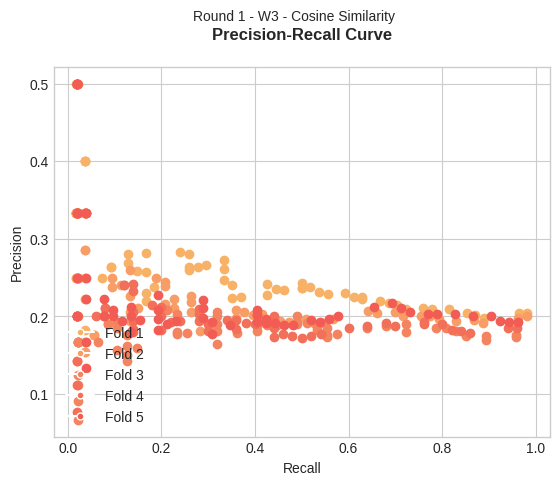

In [20]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import seaborn as sns

# colors with rgba
color_map = {
    0: '#F7B267', # red
    1: '#F79D65',
    2: '#F4845F',
    3: '#F27059',
    4: '#F25C54'
}

for round in range(1, 2):
    f_5_scores = []
    f_3_scores = []
    f_1_scores = []

    # plot pr curve
    fig, ax = plt.subplots()
    plt.style.use('seaborn-v0_8-whitegrid')
    for pr in pr_curves:
        if pr["round"] == round:
            for p in pr["prs"]:
                # exclude tuples with 0 or 1 values
                if p[0] == 0 or p[1] == 0 or p[0] == 1 or p[1] == 1:
                    continue            
                f =  pr["fold"]["f_5"]["test"]["split_label"][0]

                ax.scatter(p[1], p[0], color=color_map[f])

    # add legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Fold 1', markerfacecolor=color_map[0], markersize=5),
        Line2D([0], [0], marker='o', color='w', label='Fold 2', markerfacecolor=color_map[1], markersize=5),
        Line2D([0], [0], marker='o', color='w', label='Fold 3', markerfacecolor=color_map[2], markersize=5),
        Line2D([0], [0], marker='o', color='w', label='Fold 4', markerfacecolor=color_map[3], markersize=5),
        Line2D([0], [0], marker='o', color='w', label='Fold 5', markerfacecolor=color_map[4], markersize=5),
    ]

    ax.legend(handles=legend_elements, loc='lower left')
    #ax.set_color_cycle(sns.color_palette("Paired", 10))

    # display round and model
    model = f"{model_name[0].upper()}{model_name.split('[')[1].split(']')[0]} - {sim_measure}"

    plt.title("Precision-Recall Curve", fontsize=12, fontweight="bold", pad=20)
    plt.suptitle(f"Round {round} - {model}", fontsize=10, y=1.0)   

    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")

    fig1 = plt.gcf()
    plt.show()

    # save plot
    #fig1.savefig(f"../cross_validation/results/pr_curve_{model_name}_{sim_measure}_round_{round}.png", dpi=300)

In [23]:
from matplotlib import font_manager


def plot_precision_recall_vs_threshold(precision, recall, thresholds, round, top):
    fig, ax = plt.subplots()
    plt.plot(thresholds[0], precision[0], "--", label="Precision", color='#465775')
    plt.plot(thresholds[0], recall[0], "-", label="Recall", color='#EF6F6C')
    for i in range(1, len(precision)):
        plt.plot(thresholds[i], precision[i], "--", color='#465775')
        plt.plot(thresholds[i], recall[i], "-", color='#EF6F6C')
    
    for t in top:
        plt.axvline(x=t[0], color=t[2], linestyle=":", label=f"{t[1]} Threshold", alpha=0.8)

    tick_scores = [0.2, 0.4, 0.6, 0.8, 1.0]
    scores = [t[0] for t in top]
    too_close = []
    for t in tick_scores:
        if any(abs(t - s) < 0.1 for s in scores):
            too_close.append(t)

    for t in too_close:
        tick_scores.remove(t)

    tick_scores.append(scores[0])
    for i in range(1, len(scores)):
        if abs(scores[i] - scores[i-1]) < 0.02:
            continue
        tick_scores.append(scores[i])
        
    #tick_scores.extend(scores)
    ax.set_xticks(tick_scores, minor=False)

    plt.title("Precision-Recall vs Threshold Curve", fontsize=12, fontweight="bold", pad=10)
    plt.suptitle(f"Round {round} - {model}", fontsize=10, y=1.0)

    plt.xlabel("Threshold")
    plt.ylabel("Precision-Recall")

    font = font_manager.FontProperties(family='Rubik',
                                   style='normal', size=10)

    plt.legend(loc="lower left", prop=font)
    plt.ylim([0,1])
    plt.xlim([0,1])

    fig1 = plt.gcf()
    plt.show()

    #fig1.savefig(f"../cross_validation/results/pr_threshold_curve_{model_name}_{sim_measure}_round_{round}.png", dpi=300)

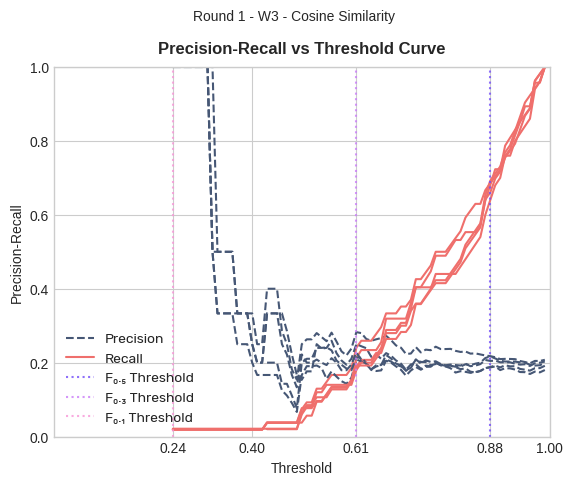

In [24]:
#display(model_results[0]["results"][0])

for r in model_results:
    rl = r["fold_split"] # round label
    fold = r["results"]
    pss = []
    rss = []
    tss = []
    top5ts = []
    top3ts = []
    top1ts = []
    for f in fold:
        ps = []
        rs = []
        ts = []
        results = f["train_results"]
        for r in results:
            # continue if any is 0
            if r["precision"] == 0 or r["recall"] == 0:
                continue
            ps.append(r["precision"])
            rs.append(r["recall"])
            ts.append(r["threshold"])
        
        pss.append(ps)
        rss.append(rs)
        tss.append(ts)


        top5ts.append(f["f_5"]["test"]["threshold"])
        top3ts.append(f["f_3"]["test"]["threshold"])
        top1ts.append(f["f_1"]["test"]["threshold"])
    
    # median threshold
    top5 = (np.median(top5ts), "F₀.₅", '#724CF9')
    top3 = (np.median(top3ts), "F₀.₃", '#CA7DF9')
    top1 = (np.median(top1ts), "F₀.₁", '#F896D8')
    
    plot_precision_recall_vs_threshold(pss, rss, tss, rl, [top5, top3, top1])